<a href="https://colab.research.google.com/github/pcashman21/feral-cat-census/blob/main/notebooks/yolo/extract_from_yolo_instance_segmentation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook extracts each object from an image using its segmentation mask predicted by the YOLO v8 feral cat segmentation model.  This code was adapted (slightly) from the code in the YOLO v8 documentation, which can be found at
https://docs.ultralytics.com/guides/isolating-segmentation-objects/#recipe-walk-through.  

The notebook processes an entire folder of files, given a set of image file types.  The resulting files, each of which has a single segmented image output (one  cat), are put into a separate folder.

This notebook assumes there is a trained model already.  See notesbooks/yolo/train_yolo_instance_segmentation_model.ipynb for the notebook on training such a model.

In [1]:
%pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.6/793.6 kB 17.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [2]:
import glob
import matplotlib.image as img
import matplotlib.pyplot as plt
from pathlib import Path
import cv2 as cv
import numpy as np
from ultralytics import YOLO
from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [16]:
IMAGE_FILENAME_ROOT = '2024-06-20'

In [17]:
!unzip '{IMAGE_FILENAME_ROOT}.zip'

Archive:  2024-06-20.zip
replace Cat pix from Box 2024-06-20/20230220_180949.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Cat pix from Box 2024-06-20/20230220_180949.jpg  
  inflating: __MACOSX/Cat pix from Box 2024-06-20/._20230220_180949.jpg  
  inflating: Cat pix from Box 2024-06-20/PXL_20230225_234527141.jpg  
  inflating: __MACOSX/Cat pix from Box 2024-06-20/._PXL_20230225_234527141.jpg  
  inflating: Cat pix from Box 2024-06-20/20230217_134624.jpg  
  inflating: __MACOSX/Cat pix from Box 2024-06-20/._20230217_134624.jpg  
  inflating: Cat pix from Box 2024-06-20/20230217_134618.jpg  
  inflating: __MACOSX/Cat pix from Box 2024-06-20/._20230217_134618.jpg  
  inflating: Cat pix from Box 2024-06-20/PXL_20230225_235721299.jpg  
  inflating: __MACOSX/Cat pix from Box 2024-06-20/._PXL_20230225_235721299.jpg  
  inflating: Cat pix from Box 2024-06-20/20230226_200901_0001.jpg  
  inflating: __MACOSX/Cat pix from Box 2024-06-20/._20230226_200901_0001.jpg  
  inflating: Cat p

In [18]:
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.5
PATH_TO_IMAGES = '/content/' + IMAGE_FILENAME_ROOT + '/*'
IMAGE_FILE_TYPES = ('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG')

In [19]:
image_paths = []
# get all image paths in dataset to process
for image_type in IMAGE_FILE_TYPES:
    image_paths.extend(glob.glob(PATH_TO_IMAGES + image_type))
# sort image_path
image_paths.sort()
image_paths

['/content/2024-06-20/20230217_125802.jpg',
 '/content/2024-06-20/20230217_125828.jpg',
 '/content/2024-06-20/20230217_125918.jpg',
 '/content/2024-06-20/20230217_125928.jpg',
 '/content/2024-06-20/20230217_125935.jpg',
 '/content/2024-06-20/20230217_130056.jpg',
 '/content/2024-06-20/20230217_130114.jpg',
 '/content/2024-06-20/20230217_130204.jpg',
 '/content/2024-06-20/20230217_130438.jpg',
 '/content/2024-06-20/20230217_130441.jpg',
 '/content/2024-06-20/20230217_130545.jpg',
 '/content/2024-06-20/20230217_130614.jpg',
 '/content/2024-06-20/20230217_130618.jpg',
 '/content/2024-06-20/20230217_133045.jpg',
 '/content/2024-06-20/20230217_134253.jpg',
 '/content/2024-06-20/20230217_134611.jpg',
 '/content/2024-06-20/20230217_134612.jpg',
 '/content/2024-06-20/20230217_134618.jpg',
 '/content/2024-06-20/20230217_134624.jpg',
 '/content/2024-06-20/20230217_134637.jpg',
 '/content/2024-06-20/20230217_134714.jpg',
 '/content/2024-06-20/20230217_134725.jpg',
 '/content/2024-06-20/20230217_1

In [20]:
SEGMENTED_FILES_FOLDER = '/content/' + IMAGE_FILENAME_ROOT + '_segmented'
!mkdir $SEGMENTED_FILES_FOLDER

mkdir: cannot create directory ‘/content/2024-06-20_segmented’: File exists


In [21]:
# This code extracts each object from an image using its segmentation mask predicted by the YOLO v8 feral cat segmentation model.
# This code was adapted (slightly) from the code in the YOLO v8 documentation, which can be found at
# https://docs.ultralytics.com/guides/isolating-segmentation-objects/#recipe-walk-through.  The numbers in parentheses refer to steps
# and explanations in that documentation.

trained_model = YOLO('/content/gdrive/MyDrive/Cat images/models/feral-cat-segmentation.v1i.yolov8/200-epochs-/weights/best.pt') #(4)!

# Set batch size to 50 so we don't blow the CUDA memory
res = []
if len(image_paths) > 50:
    batch_size = 50
else:
    batch_size = len(image_paths)
for i in range(0, len(image_paths), batch_size):
    source = image_paths[i:i+batch_size]
    results = trained_model.predict(source=source, conf=CONFIDENCE_THRESHOLD, iou=IOU_THRESHOLD) #(5)!
    res.extend(results)

# iterate detection results (5)
for r in res:
    img = np.copy(r.orig_img)
    img_name = Path(r.path).stem

    # iterate each object contour (6)
    for ci,c in enumerate(r):
        label = c.names[c.boxes.cls.tolist().pop()]

        b_mask = np.zeros(img.shape[:2], np.uint8)

        # Create contour mask (1)
        contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
        _ = cv.drawContours(b_mask, [contour], -1, (255, 255, 255), cv.FILLED)

        # Choose one:

        # OPTION-1: Isolate object with black background
        # mask3ch = cv.cvtColor(b_mask, cv.COLOR_GRAY2BGR)
        # isolated = cv.bitwise_and(mask3ch, img)

        # OPTION-2: Isolate object with transparent background (when saved as PNG)
        isolated = np.dstack([img, b_mask])

        # OPTIONAL: detection crop (from either OPT1 or OPT2)
        x1, y1, x2, y2 = c.boxes.xyxy.cpu().numpy().squeeze().astype(np.int32)
        iso_crop = isolated[y1:y2, x1:x2]

        # Save isolated object to file
        _ = cv.imwrite(f'{SEGMENTED_FILES_FOLDER}/{img_name}_{label}-{ci}.png', iso_crop)


0: 640x640 1 cat, 24.7ms
1: 640x640 1 cat, 24.7ms
2: 640x640 (no detections), 24.7ms
3: 640x640 (no detections), 24.7ms
4: 640x640 1 cat, 24.7ms
5: 640x640 (no detections), 24.7ms
6: 640x640 1 cat, 24.7ms
7: 640x640 (no detections), 24.7ms
8: 640x640 2 cats, 24.7ms
9: 640x640 1 cat, 24.7ms
10: 640x640 (no detections), 24.7ms
11: 640x640 (no detections), 24.7ms
12: 640x640 (no detections), 24.7ms
13: 640x640 (no detections), 24.7ms
14: 640x640 (no detections), 24.7ms
15: 640x640 (no detections), 24.7ms
16: 640x640 (no detections), 24.7ms
17: 640x640 (no detections), 24.7ms
18: 640x640 1 cat, 24.7ms
19: 640x640 1 cat, 24.7ms
20: 640x640 1 cat, 24.7ms
21: 640x640 (no detections), 24.7ms
22: 640x640 (no detections), 24.7ms
23: 640x640 1 cat, 24.7ms
24: 640x640 (no detections), 24.7ms
25: 640x640 1 cat, 24.7ms
26: 640x640 1 cat, 24.7ms
27: 640x640 1 cat, 24.7ms
28: 640x640 2 cats, 24.7ms
29: 640x640 1 cat, 24.7ms
30: 640x640 (no detections), 24.7ms
31: 640x640 (no detections), 24.7ms
32: 6

In [22]:
image_paths = []
# get all image paths for extracted masks and display the extracted cat
for path in glob.glob(SEGMENTED_FILES_FOLDER + '/*.png'):
    image_paths.append(path)
image_paths.sort()
image_paths


['/content/2024-06-20_segmented/20230217_125802_cat-0.png',
 '/content/2024-06-20_segmented/20230217_125828_cat-0.png',
 '/content/2024-06-20_segmented/20230217_125935_cat-0.png',
 '/content/2024-06-20_segmented/20230217_130114_cat-0.png',
 '/content/2024-06-20_segmented/20230217_130438_cat-0.png',
 '/content/2024-06-20_segmented/20230217_130438_cat-1.png',
 '/content/2024-06-20_segmented/20230217_130441_cat-0.png',
 '/content/2024-06-20_segmented/20230217_134624_cat-0.png',
 '/content/2024-06-20_segmented/20230217_134637_cat-0.png',
 '/content/2024-06-20_segmented/20230217_134714_cat-0.png',
 '/content/2024-06-20_segmented/20230217_135021_cat-0.png',
 '/content/2024-06-20_segmented/20230217_135047_cat-0.png',
 '/content/2024-06-20_segmented/20230217_135115_cat-0.png',
 '/content/2024-06-20_segmented/20230217_135128_cat-0.png',
 '/content/2024-06-20_segmented/20230217_135151_cat-0.png',
 '/content/2024-06-20_segmented/20230217_135151_cat-1.png',
 '/content/2024-06-20_segmented/20230217

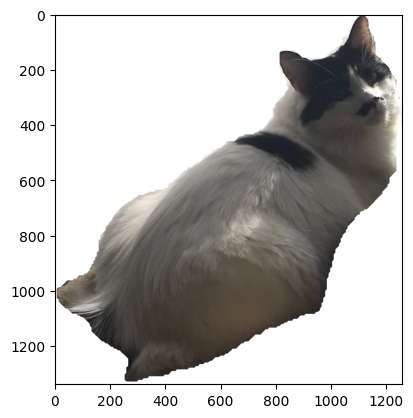

In [ ]:
#for i in range(len(image_paths)):
im = img.imread(image_paths[5])
plt.imshow(im)

In [23]:
!zip -r '{IMAGE_FILENAME_ROOT}_segmented.zip' '{IMAGE_FILENAME_ROOT}_segmented'

  adding: 2024-06-20_segmented/ (stored 0%)
  adding: 2024-06-20_segmented/20230227_040454_cat-0.png (deflated 11%)
  adding: 2024-06-20_segmented/20230226_200901_0000_cat-1.png (deflated 1%)
  adding: 2024-06-20_segmented/20230227_144534_0000_cat-5.png (deflated 2%)
  adding: 2024-06-20_segmented/20230227_144534_0000_cat-11.png (deflated 0%)
  adding: 2024-06-20_segmented/20230217_142737_cat-0.png (deflated 24%)
  adding: 2024-06-20_segmented/20230301_001349_cat-0.png (deflated 28%)
  adding: 2024-06-20_segmented/20230227_190643_0002_cat-6.png (deflated 9%)
  adding: 2024-06-20_segmented/20230227_190643_0001_cat-1.png (deflated 9%)
  adding: 2024-06-20_segmented/20230227_212457_cat-2.png (deflated 17%)
  adding: 2024-06-20_segmented/20230224_231042_cat-1.png (deflated 26%)
  adding: 2024-06-20_segmented/20230301_215241_cat-0.png (deflated 26%)
  adding: 2024-06-20_segmented/20230227_190643_0000_cat-4.png (deflated 9%)
  adding: 2024-06-20_segmented/20230227_190643_0000_cat-9.png (defl